In [30]:
from dotenv import load_dotenv, find_dotenv 

load_dotenv(find_dotenv(), override = True)

True

In [31]:
from langchain_exa import ExaSearchRetriever
from langchain_openai import ChatOpenAI 

exa_search_retriever = ExaSearchRetriever(k = 1, highlights = False, type = "keyword") 

llm = ChatOpenAI(model = "gpt-4o-mini", temperature = 0)

In [32]:
from typing_extensions import TypedDict 
from typing import Annotated 
from operator import add 

class Custom_State(TypedDict): 
    thesis: str 
    thesis_parts: Annotated[list[str], add]
    context: Annotated[list[str], add] 
    recent_thesis_part: str
    iteration_counter: int
    final_response: str

# exa_search_node

In [33]:
exa_search_retriever = ExaSearchRetriever(k = 1, highlights = False, type = "autotype")

def exa_search_node(recent_thesis_part: str):
    """Search for context from online sources. 
    This search should use the entire recent_thesis_part 
    This tool should return context for the question that was asked and the accompanying url for the context. 
    Include the url at the end of the context on a new line.
    
    Args: 
        recent_thesis_part: recent_thesis_part
    """
    # exa_search_retriever = ExaSearchRetriever(k = 1, highlights = False, type = "autotype") 
    output = exa_search_retriever.invoke(recent_thesis_part) 
    return output[0].page_content + output[0].metadata["url"]

In [63]:
def exa_search_node_new(state: Custom_State):
    """Search for context from online sources. 
    This search should use the entire recent_thesis_part 
    This tool should return context for the question that was asked and the accompanying url for the context. 
    Include the url at the end of the context on a new line.
    
    Args: 
        recent_thesis_part: recent_thesis_part
    """
    exa_search_retriever_new = ExaSearchRetriever(k = 1, highlights = False, type = "autotype")
    output = exa_search_retriever_new.invoke(state["recent_thesis_part"]) 
    return {"context": [f"Information from source {abs(state['iteration_counter'])}:\n\n" + output[0].page_content + "\n\n" + "Source URL: \n\n" + output[0].metadata["url"] + "\n\n" + ("-" * 100) + "\n\n"]}

In [35]:
llm_with_tools = ChatOpenAI(model = "gpt-4o-mini", temperature = 0).bind_tools([exa_search_node])

# Adding a Structured Output to query_parsing_node

In [36]:
from pydantic import BaseModel, Field 
from typing import Optional

class parsed_query(BaseModel): 
    """The original thesis statement split into its parts.""" 
    thesis_part_1: str = Field(description = "Thesis that has been split into its main idea/main argument and first sub-argument/reasoning.") 
    thesis_part_2: str = Field(description = "Thesis that has been split into its main idea/main argument and second sub-argument/reasoning.")
    thesis_part_3: Optional[str] = Field(description = "Thesis that has been split into its main idea/main argument and third sub-argument/reasoning.")

In [37]:
llm_2 = ChatOpenAI(model = "gpt-4o", temperature = 0) 

llm_structured = llm_2.with_structured_output(parsed_query)

# query_parsing_node

In [59]:
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import SystemMessage, HumanMessage

def query_parsing_node(state: Custom_State): 
    thesis = state["thesis"] 
    prompt_template = ChatPromptTemplate.from_template("""
        The overall goal of this LLM application is to help a user in writing their research paper based on their thesis statement that they provide. 
        However, this is the first step of the process in which you must parse the original, whole thesis into seperate sentences. 
        This will require you to analyze the thesis statement, locate its main idea as well as its sub-arguemnts/reasonings, and finally, combine the main idea with ONE of the sub-arguemnts/reasonings in each sentence. 
        Therefore, IF the original thesis statement included a main idea and 2 sub-arguments/reasonings, the final output must include 2 seperate sentences, each including the main idea and a unique sub-argument/reasoning. 
        DO NOT INCLUDE quotation marks "" in the final output. 
                                                       
        ---START OF EXAMPLES---
                                                       
        For some guidance, consider the following examples: 
                                                       
        Example 1:
                                                       
        Original thesis statement: "Mandatory school uniforms should be implemented in educational institutions as they promote a sense of equality, reduce distractions, and foster a focused and professional learning environment." 
                                                       
        Output: 
            "Mandatory school uniforms should be implemented in educational institutions as they promote a sense of equality."
            "Mandatory school uniforms should be implemented in educational institutions as they reduce distractions."
            "Mandatory school uniforms should be implemented in educational institutions as they foster a focused and professional learning environment."
                                                            
        Example 2: 
                                                        
        Original thesis statement: "Globalization has created a world more interconnected than ever before, yet it also amplifies economic disparities and cultural homogenization."
                                                        
        Output: 
            "Globalization has created a world more interconnected than ever before, yet it also amplifies economic disparities."
            "Globalization has created a world more interconnected than ever before, yet it also amplifies cultural homogenization."  
                                                            
        Example 3: 
        
        Original thesis statement: "Immigration enriches receiving countries culturally and economically, outweighing any perceived social or economic burdens." 
                                                        
        Output: 
            "Immigration enriches receiving countries culturally, outweighing any perceived social or economic burdens." 
            "Immigration enriches receiving countries economically, outweighing any perceived social or economic burdens."
                                                            
        -----END OF EXAMPLES-----
                                                        
        Original thesis statement: 
        
        {thesis}
        """)
    
    query_parsing_chain = prompt_template | llm_structured 
    parsed_thesis = query_parsing_chain.invoke({"thesis": thesis[0].content}) 
    return {"thesis_parts": [parsed_thesis.thesis_part_1, parsed_thesis.thesis_part_2, parsed_thesis.thesis_part_3], "iteration_counter": -1}
    

### Tests for query_parsing_node

In [ ]:
output = query_parsing_node({"thesis": "Social media has revolutionized communication and societal interactions, but it also presents significant challenges related to privacy, mental health, and misinformation."}) 

output = output.content 

output_2 = output.split(" #")

print(output_2)

In [ ]:
for i in output["thesis_parts"]: 
    print(i)

In [ ]:
output = query_parsing_node({"thesis": "Globalization has created a world more interconnected than ever before, yet it also amplifies economic disparities and cultural homogenization."}) 

print(output)
print(output["thesis_parts"][0])
print(output["thesis_parts"][1])
print(output["thesis_parts"][-1])

In [ ]:
output = query_parsing_node({"thesis": "Urbanization drives economic growth and social development, but it also poses unique challenges in sustainability and quality of life."}) 

print(output) 
print("-" * 50)
output_list = output.split("\n")
print(output_list)
print(type(output_list))
print("-" * 50) 
for thesis_part in output_list: 
    print(thesis_part)
    print(type(thesis_part))
    print("-" * 10)

In [ ]:
output = query_parsing_node({"thesis": "Immigration enriches receiving countries culturally and economically, outweighing any perceived social or economic burdens."}) 

print(output)

# load_thesis_part_node 

In [39]:
def load_thesis_part_node(state: Custom_State):
    # list_1 = state["thesis_parts"][0].split("\n")
    # parts = state["thesis_parts"][-1] 
    return {"recent_thesis_part": state["thesis_parts"][-1]}

In [40]:
def load_thesis_part_node_new(state: Custom_State):
    if abs(state["iteration_counter"]) <= len(state["thesis_parts"]):
        return {"recent_thesis_part": state["thesis_parts"][state["iteration_counter"]]}
    else: 
        pass

# assistant_node

In [41]:
from langgraph.graph import StateGraph, START, END

sys_msg = SystemMessage(content = """
                        You are a helpful assistant tasked with pulling text gathered from the web in order to aid the user in completing their research paper based on their provided thesis statement.
                        Use the entire provided thesis as the input for your web search. 
                        Return all text/information gathered from the web search in a raw but human readable format. 
                        At the very end, include the url from the web search that was used to gather all of this text/information and include '----------------------------------------------------' on a new line after the url as a separator between different/unique web search results. 
                        ONLY SEARCH FROM trust-worthy sources from the web search such as Google Scholar, JSTOR, ScienceDirect, and other academic databases. 
                        If a source does not seem to be trustworthy, skip the source and execute the search again, for a maximum of 3 iterations.
                        DO NOT write the user's research paper for them. 
                        
                        -------------------------------------------------------------
                        
                        USE THE THESIS PART BELOW AS THE INPUT TO 'exa_search_node'
                        """)

# prompt = ChatPromptTemplate.from_template(template = """
#                         You are a helpful assistant tasked with pulling text gathered from the web in order to aid the user in completing their research paper based on their provided thesis statement.
#                         Use the entire provided thesis as the input for your web search. 
#                         Return all text/information gathered from the web search in a raw but human readable format. 
#                         At the very end, include the url from the web search that was used to gather all of this text/information and include '----------------------------------------------------' on a new line after the url as a separator between different/unique web search results. 
#                         ONLY SEARCH FROM trust-worthy sources from the web search such as Google Scholar, JSTOR, ScienceDirect, and other academic databases. 
#                         If a source does not seem to be trustworthy, skip the source and execute the search again, for a maximum of 3 iterations.
#                         DO NOT write the user's research paper for them. 
                        
#                         -------------------------------------------------------------
                        
#                         USE THE THESIS PART BELOW AS THE INPUT TO 'exa_search_node' 
                        
#                         recent_thesis_part: {recent_thesis_part}
#                         """)

def assistant_node(state: Custom_State): 
    # chain = prompt | llm_with_tools 
    # return {"context": [chain.invoke({"recent_thesis_part": state["recent_thesis_part"]})]}
    # return {"context": [llm_with_tools.invoke([sys_msg] + [state["recent_thesis_part"]])]}
    return None

# remove_one_thesis_part_node

In [42]:
def remove_one_thesis_part_node(state: Custom_State): 
    return {"thesis_parts": state["thesis_parts"][0: -1]}

# Change iteration_counter

In [43]:
def change_iteration_counter_node(state: Custom_State): 
    return {"iteration_counter": state["iteration_counter"] - 1}

# Conditional Edge for assistant_node

In [44]:
from typing import Literal

def thesis_part_conditional_edge(state: Custom_State) -> Literal["exa_search_node", "text_and_quote_extractor_node"]: 
    if hasattr(state["context"][-1], "tool_calls") and len(state["context"][-1].tool_calls) > 0 and len(state["thesis_parts"]) > 0: 
        return "exa_search_node" 
    else: 
        return "text_and_quote_extractor_node"

In [45]:
def thesis_part_conditional_edge_new(state: Custom_State) -> Literal["exa_search_node_new", "text_and_quote_extractor_node"]: 
    if len(state["thesis_parts"]) > 0 and state["thesis_parts"][-1] != None and abs(state["iteration_counter"]) <= len(state["thesis_parts"]): 
        return "exa_search_node_new" 
    else: 
        return "text_and_quote_extractor_node"

# text_and_quote_extractor_node

In [70]:
def text_and_quote_extractor_node(state: Custom_State): 
    context = state["context"] 
    original_thesis = state["thesis"] 
    len_context = len(context)
    context_str = "" 
    for i in context: 
        context_str += str(i)
    system_message_template = ChatPromptTemplate.from_template(template = """
        Given the original thesis statement below and all of the provided context, return reasoning as to why the websites, articles, or academic papers found through the web searchs assist the user in writing their research paper. 
        You must return SPECIFIC QUOTATIONS from the websites, articles, or academic papers themselves that the user can utilize within their own research paper. 
        Display all reasoning in a numbered list format with the urls for each piece of reasoning at the end of the line. 
        DO NOT write the user's research paper for them.
        VERY IMPORTANT, USE ONLY THE PROVIDED ORIGINAL THESIS AND CONTEXT, DO NOT RETRIEVE INFORMATION FROM YOUR OWN INTERNAL DATABASE
                                   
        ----------------------------------------------------------------------------------------------------------------------------------------------
        
        **IMPORTANT**
                              
        Original Thesis Statement: **{original_thesis}**
                                   
        Given Context: 
                                   
        {context}
        """)
    text_and_quote_extractor_chain = system_message_template | llm | StrOutputParser()
    return {"final_response": text_and_quote_extractor_chain.invoke({"original_thesis": original_thesis[0].content, "context": context_str, "len_context": len_context})}

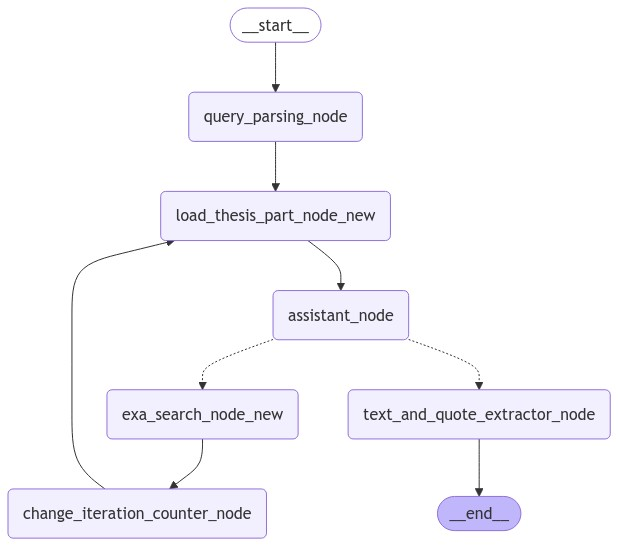

In [71]:
from IPython.display import Image, display
from langgraph.prebuilt import ToolNode, tools_condition # tools_condition is not used here 
from langgraph.checkpoint.memory import MemorySaver

builder = StateGraph(Custom_State) 

builder.add_node("query_parsing_node", query_parsing_node) 
builder.add_node("assistant_node", assistant_node)
builder.add_node("exa_search_node_new", exa_search_node_new) 
# builder.add_node("remove_one_thesis_part_node", remove_one_thesis_part_node)
builder.add_node("change_iteration_counter_node", change_iteration_counter_node)
builder.add_node("text_and_quote_extractor_node", text_and_quote_extractor_node)
builder.add_node("load_thesis_part_node_new", load_thesis_part_node_new)

builder.add_edge(START, "query_parsing_node") 
builder.add_edge("query_parsing_node", "load_thesis_part_node_new") 
builder.add_edge("load_thesis_part_node_new", "assistant_node")
builder.add_conditional_edges("assistant_node", thesis_part_conditional_edge_new)
builder.add_edge("exa_search_node_new", "change_iteration_counter_node")  
builder.add_edge("change_iteration_counter_node", "load_thesis_part_node_new")
builder.add_edge("text_and_quote_extractor_node", END)

graph = builder.compile(checkpointer = MemorySaver()) # interrupt_before = ["load_thesis_part_node"]

display(Image(graph.get_graph(xray = True).draw_mermaid_png()))

In [72]:
config = {"configurable": {"thread_id": "thesis_agent_example_2"}}

thesis_statement = [HumanMessage(content = "Mandatory school uniforms should be implemented in educational institutions as they promote a sense of equality, reduce distractions, and foster a focused and professional learning environment.")]
complete_message = graph.invoke({"thesis": thesis_statement}, config = config) 

print(complete_message) 
print("-" * 50) 
print(complete_message["final_response"])

{'thesis': [HumanMessage(content='Mandatory school uniforms should be implemented in educational institutions as they promote a sense of equality, reduce distractions, and foster a focused and professional learning environment.', additional_kwargs={}, response_metadata={})], 'thesis_parts': ['Mandatory school uniforms should be implemented in educational institutions as they promote a sense of equality.', 'Mandatory school uniforms should be implemented in educational institutions as they reduce distractions.', 'Mandatory school uniforms should be implemented in educational institutions as they foster a focused and professional learning environment.'], 'context': ['Information from source 1:\n\ntrack order\n   user login\nOne stop solution for school related shopping\n"ShopforSchool.in is a dynamic online platform, making one-stop-shopping a satisfying experience by delivering a wide range of quality products at your doorstep. We house unique products, ranging from books to stationery 

In [ ]:
from pprint import pprint

state = graph.get_state(config) 
pprint(state)

In [76]:
import uuid 

id = uuid.uuid1() 

uuid_int = id.int

config_uuid = {"configurable": {"thread_id": f"thesis_agent_example_{uuid_int}"}}

thesis_statement = [HumanMessage(content = "Social media has revolutionized communication and societal interactions, but it also presents significant challenges related to privacy, mental health, and misinformation.")]
complete_message = graph.invoke({"thesis": thesis_statement}, config = config_uuid) 

print(complete_message) 
print("-" * 50) 
print(complete_message["final_response"])

{'thesis': [HumanMessage(content='Social media has revolutionized communication and societal interactions, but it also presents significant challenges related to privacy, mental health, and misinformation.', additional_kwargs={}, response_metadata={})], 'thesis_parts': ['Social media has revolutionized communication and societal interactions, but it also presents significant challenges related to privacy.', 'Social media has revolutionized communication and societal interactions, but it also presents significant challenges related to mental health.', 'Social media has revolutionized communication and societal interactions, but it also presents significant challenges related to misinformation.'], 'context': ['Information from source 1:\n\nSection navigation\nWHO and partners recognize that misinformation online has the potential to travel further, faster and sometimes deeper than the truth — on some social media platforms, falsehoods are 70% more likely to get shared than accurate news.